In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

sys.path.append(r"../")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath, multidevice, groutine
from CrystalDiff.SplitDelayCrystalModel import get_crystal_in_delay_fixed_branch, get_crystals_in_delayed_branch
from CrystalDiff.SplitDelayCrystalModel import align_delay_fixed_branch, align_delayed_branch, get_light_path

# Define the pulse and grating

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Grating
# ---------------------------------------------------------------------------------------------------------- 
grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(0.25)
grating_list[0].set_b(0.25)
grating_list[1].set_a(0.25)
grating_list[1].set_b(0.25)


# -----------------------
#   Set spatial position
# -----------------------
# Grating_position_1
g_position_1 = np.array([252.70, 660.04, 140.04]) * 1000 + np.array([0, 652.5484, -2.9e6])
grating_list[0].set_surface_point(g_position_1)

g_position_2 = np.array([252.63, 659.55, 1065.14]) * 1000 + np.array([0, -652.5484, 2.1e6])
grating_list[1].set_surface_point(g_position_2)


# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 9.83  # keV
pre_length = 1e6    # Distance of the pulse from the first grating

# Set up the pulse
FWHM = 150 # (um)

my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[1., 0., 0.],
                              sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=1.55,
                              x0=g_position_1 - np.array([0., 0., pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                      Grating splitting angle
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(grating_list[0].base_wave_vector[1] / my_pulse.klen0)  # This is the deviation angle.

# Define and align crystals

In [3]:
lattice_distance = 1.9201 * 1e-4   # Lattice plane distance in um

chi_dict = {"chi0": complex(-0.10106E-04, 0.15913E-06),
            "chih_sigma": complex(0.61405E-05, -0.15323E-06),
            "chihbar_sigma": complex(0.61405E-05, -0.15323E-06),
            "chih_pi": complex(0.48157E-05, -0.11872E-06),
            "chihbar_pi": complex(0.48157E-05, -0.11872E-06)
            }

# Crystal in Delayed branch
crystal_list_1 = get_crystals_in_delayed_branch(asymmetric_angles=np.deg2rad(np.array([0,-5,5,0,
                                                                                       0,5,-5,0])),
                                               lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

# Crystal in Delay fixed branch
crystal_list_2 = get_crystal_in_delay_fixed_branch(lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

###################################################################
#    Align the crystals
###################################################################
# Bragg angle
bragg = np.radians(19.174)

#################################################################
#        Delayed Branch
#################################################################
crystal_list_1 = align_delayed_branch(delayed_branch_crystals = crystal_list_1,
                                      angle_offset = dtheta,
                                      bragg = bragg + 523e-6,
                                      tweak = np.array([0,-995e-6,-995e-6,0]))

#################################################################
#        Delay-fixed Branch
#################################################################
crystal_list_2 = align_delay_fixed_branch(delay_fixed_branch_crystals = crystal_list_2,
                                          angle_offset = -dtheta,
                                          bragg =  bragg + 522e-6,
                                          tweak = 1010e-6)

# Tune crystal positions to achieve spatial and temporal overlap

In [4]:
t23_motion = 1263.0686890313366
t5_motion = -358.

(new_path_upper,
 new_path_lower,
 new_crystal,
 new_crystal_lower) = get_light_path(ref_crystal_up = crystal_list_1,
                                     ref_crystal_low = crystal_list_2,
                                     ref_grating = grating_list,
                                     ref_pulse = my_pulse,
                                     shift_upper = np.array([2325.5 - 360 + t23_motion, ] * 2 +
                                                            [-2325.5 - 360 + t23_motion,] * 2 + 
                                                            [0,] * 2 +
                                                            [3961 + t5_motion,] * 2),
                                     shift_lower = [0,] * 2 + [1900,]*2,
                                     pathlength=8e6)

In [5]:
print("-------------------------------")
print("Grating position: ")
print("New upper: {:.4f}".format(new_path_upper[0][-2, 1]))
print("New lower: {:.4f}".format(new_path_lower[0][-2, 1]))

print("-------------------------------")
print("Light Path position: ")
print("New upper: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])))
print("New lower: {:.4f}".format(util.get_total_path_length(new_path_lower[0][:-1])))
print("Difference: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])
                                 -util.get_total_path_length(new_path_lower[0][:-1])))

-------------------------------
Grating position: 
New upper: 660424.1915
New lower: 660425.7941
-------------------------------
Light Path position: 
New upper: 6958569.4852
New lower: 6958569.3536
Difference: 0.1317


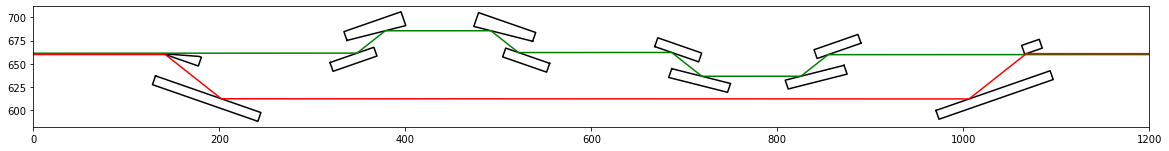

In [6]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([new_crystal[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')
    
for x in range(4):
    ax.plot([new_crystal_lower[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal_lower[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(new_path_upper[0][:,2]/1000,
        new_path_upper[0][:,1]/1000,'g')

ax.plot(new_path_lower[0][:,2]/1000,
        new_path_lower[0][:,1]/1000,'r')

ax.set_aspect("equal")
ax.set_xlim([0, 1200])

plt.show()

# Get the 2D field

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 2 ** 9
number_z = 2 ** 15
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                          number_y=number_y,
                                                          number_z=number_z,
                                                          delta_e_x=1e-50,
                                                          delta_e_y=5e-4,
                                                          delta_e_z=2e-3)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

In [8]:
total_path = 8e6
observation = new_path_upper[0][-1]

crystal_list = list(range(10))
crystal_list[0] = grating_list[0]
crystal_list[1:-1] = new_crystal[:]
crystal_list[-1] = grating_list[1]

# Set the range of the index to save
z_idx_range = 1024
num1 = 800
num2 = z_idx_range - num1
d_num = 512

# -------------------------------------------------------------
#            Get Field for variable branch
# -------------------------------------------------------------
tic = time.time()

(result_3d_var,
 result_2d_var,
 check_var
) = groutine.get_diffraction_field(crystal_list = crystal_list,
                                 total_path = total_path, 
                                 observation = observation,
                                 my_pulse = my_pulse,
                                 kx_grid = kx_grid,
                                 ky_grid = ky_grid,
                                 kz_grid = kz_grid,
                                 pulse_delay_time = 0.,
                                 pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                 grating_orders = [1.,-1],
                                 number_x = number_x,
                                 number_y = number_y,
                                 number_z = number_z,
                                 z_idx_range = z_idx_range,
                                idx_start_1=number_z - num1,
                                idx_start_2=0,
                                 num1 = num1,
                                 num2 = num2, 
                                 d_num = 512)


toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.05 seconds to prepare the variables.
It takes 20.63 seconds to get the field for branch 1.


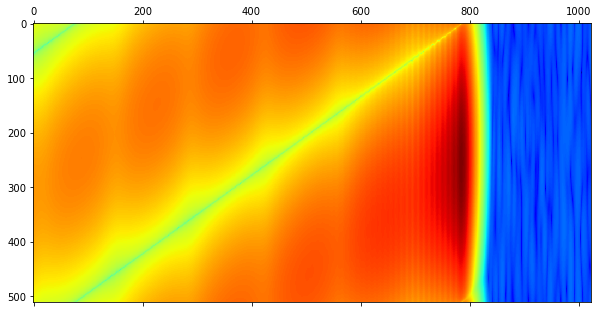

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

field_var = np.fft.ifftshift(np.fft.ifft(result_2d_var['x_field_2d'], axis=0), axes=0)

im = axes.matshow(np.log(np.square(np.abs(field_var))),
                  cmap='jet',)

#fig.colorbar(im, ax=axes )
plt.show()

# Create a prism and find the corresponding field

In [10]:
wave_vec_new = np.array([0., np.tan(-5e-6) * my_pulse.klen0, 0.])
prism = crystal.Prism(additional_wavevector=wave_vec_new)

In [11]:
total_path = 8e6
observation = new_path_upper[0][-1]

crystal_list = list(range(7))
crystal_list[0] = grating_list[0]
crystal_list[1] = new_crystal_lower[0]
crystal_list[2] = new_crystal_lower[1]
crystal_list[3] = prism
crystal_list[4] = new_crystal_lower[2]
crystal_list[5] = new_crystal_lower[3]
crystal_list[-1] = grating_list[1]

# Set the range of the index to save
z_idx_range = 1024
num1 = 800
num2 = z_idx_range - num1
d_num = 512

# -------------------------------------------------------------
#            Get Field for variable branch
# -------------------------------------------------------------
tic = time.time()

(result_3d_fix,
 result_2d_fix,
 check_fix
) = groutine.get_diffraction_field(crystal_list = crystal_list,
                                 total_path = total_path, 
                                 observation = observation,
                                 my_pulse = my_pulse,
                                 kx_grid = kx_grid,
                                 ky_grid = ky_grid,
                                 kz_grid = kz_grid,
                                 pulse_delay_time = 0.,
                                 pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                 grating_orders = [-1.,1],
                                 number_x = number_x,
                                 number_y = number_y,
                                 number_z = number_z,
                                 z_idx_range = z_idx_range,
                                   idx_start_1=number_z - num1,
                                   idx_start_2=0,
                                 num1 = num1,
                                 num2 = num2, 
                                 d_num = 512)


toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.03 seconds to prepare the variables.
It takes 13.37 seconds to get the field for branch 1.


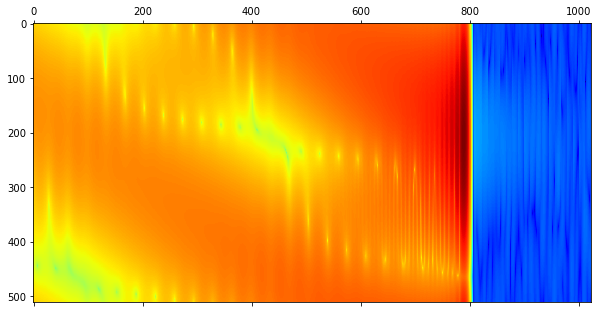

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

field_fix = np.fft.ifftshift(np.fft.ifft(result_2d_fix['x_field_2d'], axis=0), axes=0)

im = axes.matshow(np.log(np.square(np.abs(field_fix))),
                  cmap='jet',)

#fig.colorbar(im, ax=axes )
plt.show()

# Tweak the position of the delayed branch output a little bit
Because different spatial overlap quality significantly change the visibitliy value. Therefore, we tweak the position a little bit here.

In [13]:
# Roll the delayed branch a little bit
field_var_new = np.roll(field_var, -100, axis=0)

# Add the two field and get the new field
new_field = field_fix + field_var_new
new_intensity = np.square(np.abs(new_field))

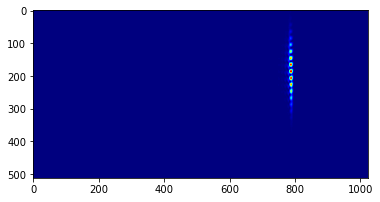

In [14]:
plt.imshow(new_intensity, cmap='jet')
plt.show()

# Get visibility

In [15]:
holder = np.zeros((200, 512))

for x in range(-100, 100):
    
    #print(x)
    
    rolled_delayed_branch = np.roll(field_var_new, x, axis=1)
    
    tmp = field_fix + rolled_delayed_branch
    tmp = np.square(np.abs(tmp))
    holder[x] = np.sum(tmp, axis=-1) / np.mean(np.sum(tmp, axis=-1))
    
    
# Get fft
holder_fft = np.fft.ifftshift(np.fft.fft(holder, axis=-1))
holder_fft = np.abs(holder_fft) / holder_fft.shape[1] * 2

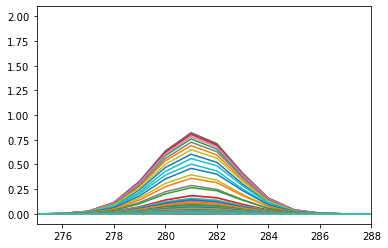

In [16]:
plt.plot(holder_fft.T)
plt.xlim([275,288])
plt.show()

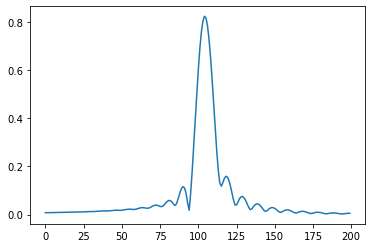

In [17]:
plt.plot(holder_fft[:,281])
plt.show()